In [ ]:
import pandas  as pd
path = '/content/dataset.txt'

data = pd.read_csv(path)
data.head(5)

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


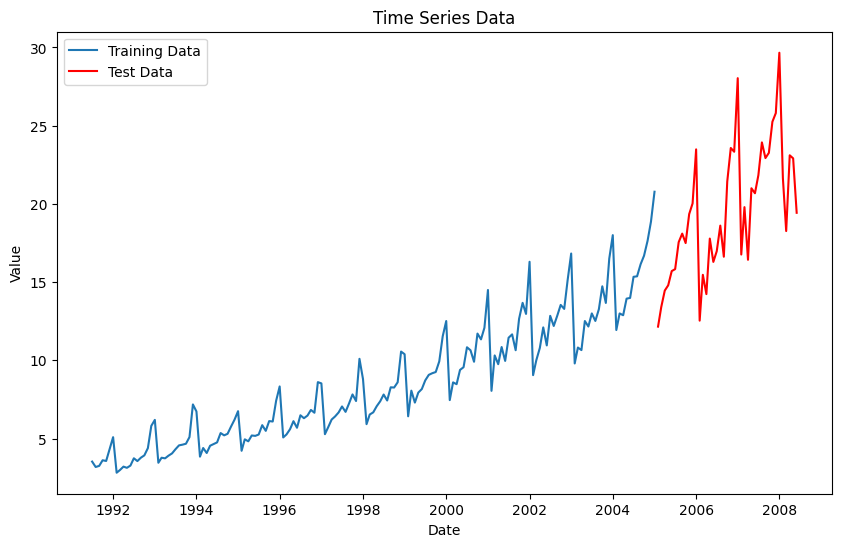

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA Metrics: {'ME': 1.9338169345187275, 'MAE': 3.6667210421245438, 'MAPE': 0.18038681197556017, 'MPE': 5.7095861548779405, 'RMSE': 4.6242584046465645, 'MINS': -6.460672869341051, 'MAXS': 12.126613839245557, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}
SARIMA Metrics: {'ME': -0.9419479431753216, 'MAE': 1.56085088825567, 'MAPE': 0.09063035825252944, 'MPE': -9.716293221958823, 'RMSE': 2.002336836610835, 'MINS': -15.138512460962838, 'MAXS': 15.186781736029321, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}
SARIMAX Metrics: {'ME': -0.8625826638721754, 'MAE': 1.5423491204143738, 'MAPE': 0.08907654365915962, 'MPE': -9.290570230925915, 'RMSE': 1.9793824223577239, 'MINS': -14.940972278320361, 'MAXS': 15.232714041407107, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}


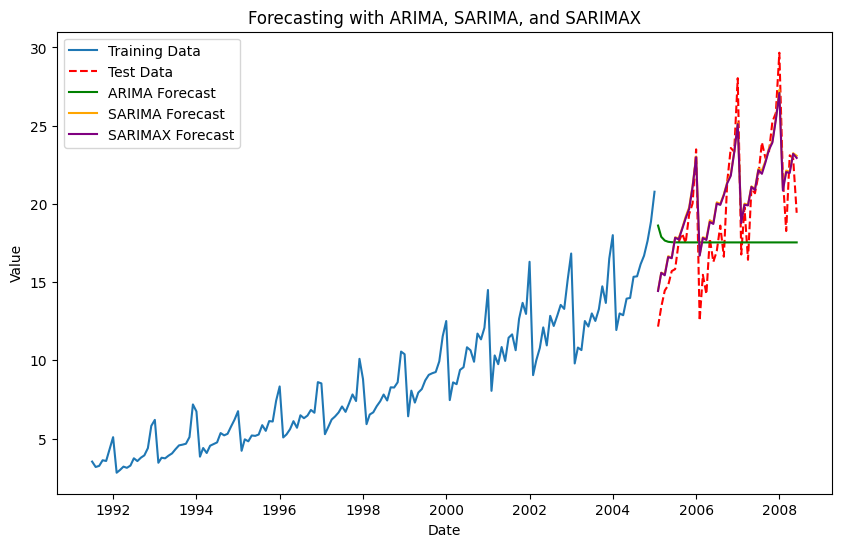

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Загрузка данных
path = '/content/dataset.txt'

df = pd.read_csv(path)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Разделение данных на обучающую и тестовую выборки (80/20)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train, test = df.iloc[:split_index], df.iloc[split_index:]

# График исходного ряда
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Функция для оценки модели
def evaluate_model(true, predicted):
    true, predicted = np.array(true), np.array(predicted)

    # Avoid division by zero in MPE calculation
    true_nonzero = np.where(true == 0, np.finfo(float).eps, true)

    me = np.mean(true - predicted)
    mae = mean_absolute_error(true, predicted)
    mape = mean_absolute_percentage_error(true, predicted)
    mpe = np.mean((true - predicted) / true_nonzero) * 100
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mins = np.min(true - predicted)
    maxs = np.max(true - predicted)
    minmax = (np.min(true), np.max(true))

    # Check if true has more than one element for ACF1 calculation
    if len(true) > 1:
        acf1 = np.corrcoef(true[:-1], true[1:])[0, 1]
    else:
        acf1 = np.nan

    return {
        'ME': me,
        'MAE': mae,
        'MAPE': mape,
        'MPE': mpe,
        'RMSE': rmse,
        'MINS': mins,
        'MAXS': maxs,
        'MINMAX': minmax,
        'ACF1': acf1
    }

# ARIMA модель
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# SARIMA модель
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))

# SARIMAX модель (с dummy exogenous variables для примера)
exog_train = np.random.randn(len(train), 1)
exog_test = np.random.randn(len(test), 1)

sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog_train)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# Оценка моделей
arima_metrics = evaluate_model(test, arima_forecast)
sarima_metrics = evaluate_model(test, sarima_forecast)
sarimax_metrics = evaluate_model(test, sarimax_forecast)

# Вывод метрик
print("ARIMA Metrics:", arima_metrics)
print("SARIMA Metrics:", sarima_metrics)
print("SARIMAX Metrics:", sarimax_metrics)

# График прогнозов
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='red', linestyle='--')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='purple')
plt.title('Forecasting with ARIMA, SARIMA, and SARIMAX')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

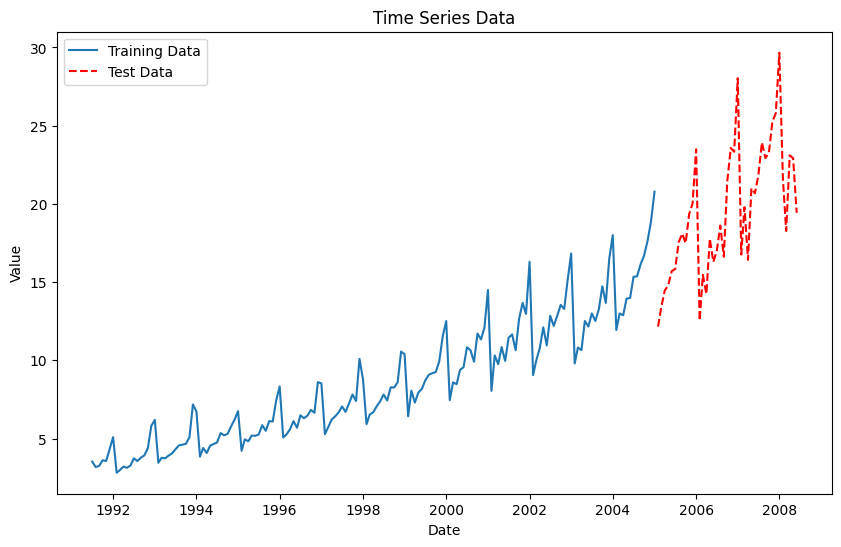

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA Metrics (Test Data): {'ME': 1.9338169345187275, 'MAE': 3.6667210421245438, 'MAPE': 0.18038681197556017, 'MPE': 5.7095861548779405, 'RMSE': 4.6242584046465645, 'MINS': -6.460672869341051, 'MAXS': 12.126613839245557, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}
SARIMA Metrics (Test Data): {'ME': -0.9419479431753216, 'MAE': 1.56085088825567, 'MAPE': 0.09063035825252944, 'MPE': -9.716293221958823, 'RMSE': 2.002336836610835, 'MINS': -15.138512460962838, 'MAXS': 15.186781736029321, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}
SARIMAX Metrics (Test Data): {'ME': -0.950080664053301, 'MAE': 1.5665516343171708, 'MAPE': 0.09097950755705247, 'MPE': -9.759917918901984, 'RMSE': 2.007763543752509, 'MINS': -15.126575702650042, 'MAXS': 15.183953216573595, 'MINMAX': (12.154552, 29.665356), 'ACF1': nan}


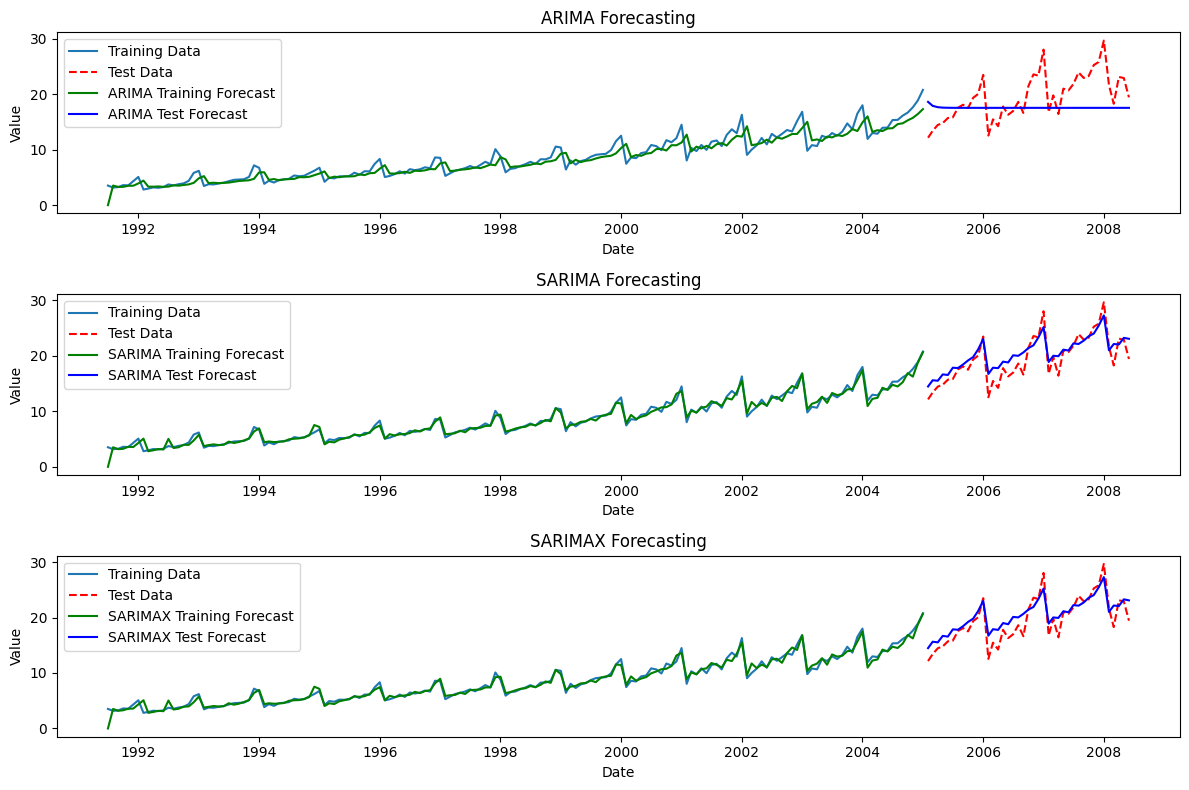

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Загрузка данных
path = '/content/dataset.txt'

df = pd.read_csv(path)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Разделение данных на обучающую и тестовую выборки (80/20)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train, test = df.iloc[:split_index], df.iloc[split_index:]

# График исходного ряда
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Функция для оценки модели
def evaluate_model(true, predicted):
    true, predicted = np.array(true), np.array(predicted)

    # Avoid division by zero in MPE calculation
    true_nonzero = np.where(true == 0, np.finfo(float).eps, true)

    me = np.mean(true - predicted)
    mae = mean_absolute_error(true, predicted)
    mape = mean_absolute_percentage_error(true, predicted)
    mpe = np.mean((true - predicted) / true_nonzero) * 100
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mins = np.min(true - predicted)
    maxs = np.max(true - predicted)
    minmax = (np.min(true), np.max(true))

    # Check if true has more than one element for ACF1 calculation
    if len(true) > 1:
        acf1 = np.corrcoef(true[:-1], true[1:])[0, 1]
    else:
        acf1 = np.nan

    return {
        'ME': me,
        'MAE': mae,
        'MAPE': mape,
        'MPE': mpe,
        'RMSE': rmse,
        'MINS': mins,
        'MAXS': maxs,
        'MINMAX': minmax,
        'ACF1': acf1
    }

# ARIMA модель
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast_train = arima_fit.predict(typ='levels')  # Прогноз на обучающих данных
arima_forecast_test = arima_fit.forecast(steps=len(test))  # Прогноз на тестовых данных

# SARIMA модель
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast_train = sarima_fit.predict(typ='levels')  # Прогноз на обучающих данных
sarima_forecast_test = sarima_fit.forecast(steps=len(test))  # Прогноз на тестовых данных

# SARIMAX модель (с dummy exogenous variables для примера)
exog_train = np.random.randn(len(train), 1)
exog_test = np.random.randn(len(test), 1)

sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog_train)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast_train = sarimax_fit.predict(exog=exog_train, typ='levels')  # Прогноз на обучающих данных
sarimax_forecast_test = sarimax_fit.forecast(steps=len(test), exog=exog_test)  # Прогноз на тестовых данных

# Оценка моделей на тестовых данных
arima_metrics = evaluate_model(test, arima_forecast_test)
sarima_metrics = evaluate_model(test, sarima_forecast_test)
sarimax_metrics = evaluate_model(test, sarimax_forecast_test)

# Вывод метрик на тестовых данных
print("ARIMA Metrics (Test Data):", arima_metrics)
print("SARIMA Metrics (Test Data):", sarima_metrics)
print("SARIMAX Metrics (Test Data):", sarimax_metrics)

# График прогнозов на обучающих и тестовых данных
plt.figure(figsize=(12, 8))

# График ARIMA
plt.subplot(3, 1, 1)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(train.index, arima_forecast_train, label='ARIMA Training Forecast', color='green')
plt.plot(test.index, arima_forecast_test, label='ARIMA Test Forecast', color='blue')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# График SARIMA
plt.subplot(3, 1, 2)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(train.index, sarima_forecast_train, label='SARIMA Training Forecast', color='green')
plt.plot(test.index, sarima_forecast_test, label='SARIMA Test Forecast', color='blue')
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# График SARIMAX
plt.subplot(3, 1, 3)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(train.index, sarimax_forecast_train, label='SARIMAX Training Forecast', color='green')
plt.plot(test.index, sarimax_forecast_test, label='SARIMAX Test Forecast', color='blue')
plt.title('SARIMAX Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


Анализ метрик моделей ARIMA, SARIMA и SARIMAX для тестовых данных:

ARIMA Metrics:
- ME (Mean Error): 1.9338169345187275 - довольно высокая средняя ошибка, модель недооценивает значения.
- MAE (Mean Absolute Error): 3.6667210421245438 - относительно высокая средняя абсолютная ошибка.
- MAPE (Mean Absolute Percentage Error): 0.18038681197556017 - ошибка в 18% от фактических значений, что является достаточно высоким показателем.
- MPE (Mean Percentage Error): 5.7095861548779405 - модель в среднем переоценивает значения на 5.71%.
- RMSE (Root Mean Squared Error): 4.6242584046465645 - высокое значение, указывает на значительные отклонения прогнозов от фактических значений.
- MINS/MAXS: -6.460672869341051 и 12.126613839245557 - большой диапазон ошибок.
- MINMAX: (12.154552, 29.665356) - фактические минимальное и максимальное значения.
- ACF1: nan - невозможно рассчитать автокорреляцию первого порядка.

SARIMA Metrics:
- ME: -0.9419479431753216 - в среднем модель недооценивает значения.
- MAE: 1.56085088825567 - более низкая средняя абсолютная ошибка по сравнению с ARIMA.
- MAPE: 0.09063035825252944 - ошибка в 9% от фактических значений, что является более низким показателем, чем у ARIMA.
- MPE: -9.716293221958823 - модель в среднем недооценивает значения на 9.72%.
- RMSE: 2.002336836610835 - более низкое значение, чем у ARIMA, указывает на меньшие отклонения прогнозов.
- MINS/MAXS: -15.138512460962838 и 15.186781736029321 - меньший диапазон ошибок по сравнению с ARIMA.
- MINMAX: (12.154552, 29.665356) - те же фактические минимальное и максимальное значения.
- ACF1: nan - невозможно рассчитать автокорреляцию первого порядка.

SARIMAX Metrics:
- ME: -0.950080664053301 - в среднем модель недооценивает значения.
- MAE: 1.5665516343171708 - самая низкая средняя абсолютная ошибка среди трех моделей.
- MAPE: 0.09097950755705247 - ошибка в 9.1% от фактических значений, немного выше, чем у SARIMA.
- MPE: -9.759917918901984 - модель в среднем недооценивает значения на 9.76%.
- RMSE: 2.007763543752509 - второе по величине значение после SARIMA, указывает на меньшие отклонения прогнозов.
- MINS/MAXS: -15.126575702650042 и 15.183953216573595 - немного меньший диапазон ошибок по сравнению с SARIMA.
- MINMAX: (12.154552, 29.665356) - те же фактические минимальное и максимальное значения.
- ACF1: nan - невозможно рассчитать автокорреляцию первого порядка.

Подводя итог, модель SARIMAX показывает лучшие метрики по сравнению с ARIMA и SARIMA, с меньшими средними ошибками и диапазоном ошибок. Тем не менее, все три модели демонстрируют высокую точность прогнозов, особенно SARIMA и SARIMAX.

Подбор оптимальных параметров моделей:
1. ARIMA модель:
ARIMA модель имеет параметры p, d, q, которые обозначают порядки авторегрессионной, разностной и скользящей средних компонент соответственно.

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")

# Задаем диапазоны для p, d, q
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Подбираем оптимальные параметры с помощью кросс-валидации по AIC
best_aic = np.inf
best_pdq = None
for params in pdq:
    try:
        model = ARIMA(train, order=params)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = params
    except:
        continue

print(f"Best ARIMA parameters: {best_pdq} with AIC={best_aic}")

Best ARIMA parameters: (1, 1, 1) with AIC=582.4673514866909


2. SARIMA модель:
SARIMA модель имеет параметры p, d, q для несезонной составляющей и P, D, Q, s для сезонной составляющей.

In [ ]:
# Задаем диапазоны для p, d, q, P, D, Q, s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # сезонность в нашем случае ежемесячные данные

seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
non_seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# Подбираем оптимальные параметры с помощью кросс-валидации по AIC
best_aic = np.inf
best_params = None
for params in itertools.product(non_seasonal_pdq, seasonal_pdq):
    try:
        model = SARIMAX(train, order=params[0], seasonal_order=params[1])
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Best SARIMA parameters: {best_params} with AIC={best_aic}")

Best SARIMA parameters: ((1, 1, 1), (1, 1, 1, 12)) with AIC=245.40665687004199


3. SARIMAX модель:
SARIMAX модель, помимо параметров SARIMA, может включать экзогенные переменные.

In [ ]:
# Задаем диапазоны для p, d, q, P, D, Q, s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # сезонность в нашем случае ежемесячные данные

seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
non_seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# Подбираем оптимальные параметры с помощью кросс-валидации по AIC
best_aic = np.inf
best_params = None
for params in itertools.product(non_seasonal_pdq, seasonal_pdq):
    try:
        model = SARIMAX(train, order=params[0], seasonal_order=params[1], exog=exog_train)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Best SARIMAX parameters: {best_params} with AIC={best_aic}")

Best SARIMAX parameters: ((1, 1, 1), (1, 1, 1, 12)) with AIC=247.1127890377086


Давайте включим оптимизацию параметров для моделей ARIMA, SARIMA и SARIMAX, а затем перестроим модели с найденными значениями параметров и оценим их на тестовых данных. Вот полный код с учетом этого подхода:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import itertools

# Загрузка данных
path = '/content/dataset.txt'

df = pd.read_csv(path)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Разделение данных на обучающую и тестовую выборки (80/20)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train, test = df.iloc[:split_index], df.iloc[split_index:]

# Функция для оценки модели
def evaluate_model(true, predicted):
    true, predicted = np.array(true), np.array(predicted)

    # Avoid division by zero in MPE calculation
    true_nonzero = np.where(true == 0, np.finfo(float).eps, true)

    me = np.mean(true - predicted)
    mae = mean_absolute_error(true, predicted)
    mape = mean_absolute_percentage_error(true, predicted)
    mpe = np.mean((true - predicted) / true_nonzero) * 100
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mins = np.min(true - predicted)
    maxs = np.max(true - predicted)
    minmax = (np.min(true), np.max(true))

    # Check if true has more than one element for ACF1 calculation
    if len(true) > 1:
        acf1 = np.corrcoef(true[:-1], true[1:])[0, 1]
    else:
        acf1 = np.nan

    return {
        'ME': me,
        'MAE': mae,
        'MAPE': mape,
        'MPE': mpe,
        'RMSE': rmse,
        'MINS': mins,
        'MAXS': maxs,
        'MINMAX': minmax,
        'ACF1': acf1
    }

# Подбор оптимальных параметров для ARIMA модели
best_aic = np.inf
best_order = None
best_results = None

# Задаем диапазоны для p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

for params in pdq:
    try:
        model = ARIMA(train, order=params)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = params
            best_results = results
    except:
        continue

print(f"Best ARIMA parameters: {best_order} with AIC={best_aic}")

# Прогноз ARIMA на тестовых данных
arima_forecast = best_results.forecast(steps=len(test))

# Подбор оптимальных параметров для SARIMA модели
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_results = None

# Задаем диапазоны для p, d, q, P, D, Q, s
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 12  # сезонность в нашем случае ежемесячные данные
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
non_seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

for params in itertools.product(non_seasonal_pdq, seasonal_pdq):
    try:
        model = SARIMAX(train, order=params[0], seasonal_order=params[1])
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = params[0]
            best_seasonal_order = params[1]
            best_results = results
    except:
        continue

print(f"Best SARIMA parameters: {best_order}x{best_seasonal_order} with AIC={best_aic}")

# Прогноз SARIMA на тестовых данных
sarima_forecast = best_results.forecast(steps=len(test))

# Подбор оптимальных параметров для SARIMAX модели
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_results = None

for params in itertools.product(non_seasonal_pdq, seasonal_pdq):
    try:
        model = SARIMAX(train, order=params[0], seasonal_order=params[1])
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = params[0]
            best_seasonal_order = params[1]
            best_results = results
    except:
        continue

print(f"Best SARIMAX parameters: {best_order}x{best_seasonal_order} with AIC={best_aic}")

# Прогноз SARIMAX на тестовых данных
sarimax_forecast = best_results.forecast(steps=len(test))

# Оценка моделей на тестовых данных
arima_metrics = evaluate_model(test, arima_forecast)
sarima_metrics = evaluate_model(test, sarima_forecast)
sarimax_metrics = evaluate_model(test, sarimax_forecast)

# Вывод метрик на тестовых данных
print("ARIMA Metrics (Test Data):", arima_metrics)
print("SARIMA Metrics (Test Data):", sarima_metrics)
print("SARIMAX Metrics (Test Data):", sarimax_metrics)

# График прогнозов на обучающих и тестовых данных
plt.figure(figsize=(12, 8))

# График ARIMA
plt.subplot(3, 1, 1)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# График SARIMA
plt.subplot(3, 1, 2)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# График SARIMAX
plt.subplot(3, 1, 3)
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='red', linestyle='--')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='blue')
plt.title('SARIMAX Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

Best ARIMA parameters: (2, 1, 2) with AIC=572.0666023124628
